In [67]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [68]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def preprocess_data(df):
    df.drop(index=[0, 1], inplace=True, errors='ignore')
    if 'Price' in df.columns:
        df.rename(columns={'Price': 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date', 'Close'], inplace=True)
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df.dropna(subset=['Close'], inplace=True)
    
    return df  # ✅ Must return 3 items


In [69]:
def create_sequences(data, time_step=60):
    X = []
    y = []
    
    for i in range(time_step, len(data)):
        X.append(data[i - time_step:i])  # Taking the last 60 days' closing prices
        y.append(data[i])  # Target: the next day's closing price
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


In [70]:
def build_model(input_shape):
    model = Sequential()

    # Adding LSTM layers with Dropout
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))  # Dropout layer to prevent overfitting

    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dropout(0.2))

    # Dense layer to output a single value
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model


# AAPL

In [71]:
import os,sys
sys.path.append(os.path.abspath('..'))

In [72]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\AAPL.csv'

In [73]:
data = pd.read_csv(path)

In [74]:
data = preprocess_data(data)

In [77]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [78]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [79]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [80]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 76ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1.7251e-04 - val_loss: 0.0027
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 2.0358e-04 - val_loss: 6.8619e-04
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.5817e-04 - val_loss: 0.0020
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1.6455e-04 - val_loss: 0.0013
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1.3495e-04 - val_loss: 0.0020
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 1.3058e-04 - val_loss: 0.0029
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.5239e-04 - val_loss: 4.9986e-04
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 9.5379e-05 - val_loss: 5.2183e-04
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 1.3034e-04 - val_loss: 0.0011
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 9.1912e-05 - val_loss: 0.0096

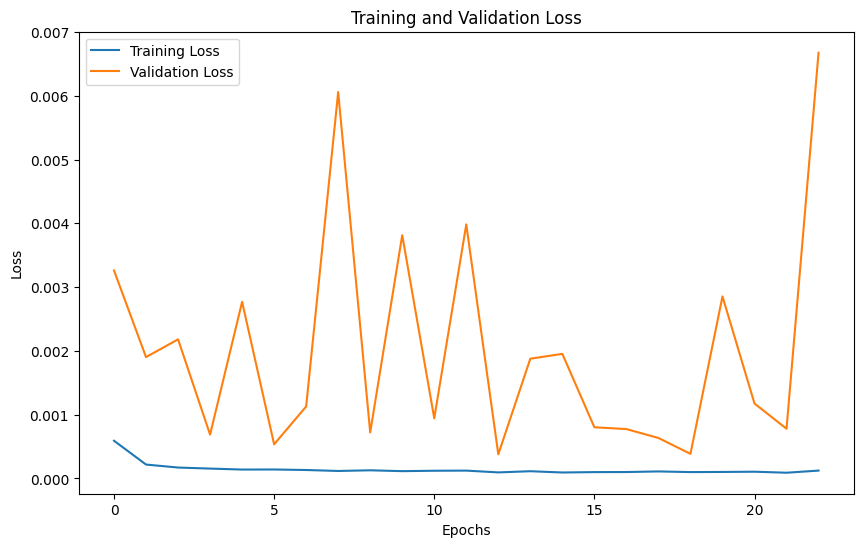

In [99]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [100]:
# Save the trained model
model.save(f'model/AAPL_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [101]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.0907e-04
Validation Loss: 0.0003784197906497866


In [102]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/AAPL_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step


In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 25.2688
📉 Root Mean Squared Error (RMSE): 5.0268
📉 Mean Absolute Error (MAE): 3.9884
📈 R² Score: 0.9755


C:\Users\POOJA\AppData\Local\Temp\ipykernel_3604\2774469258.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


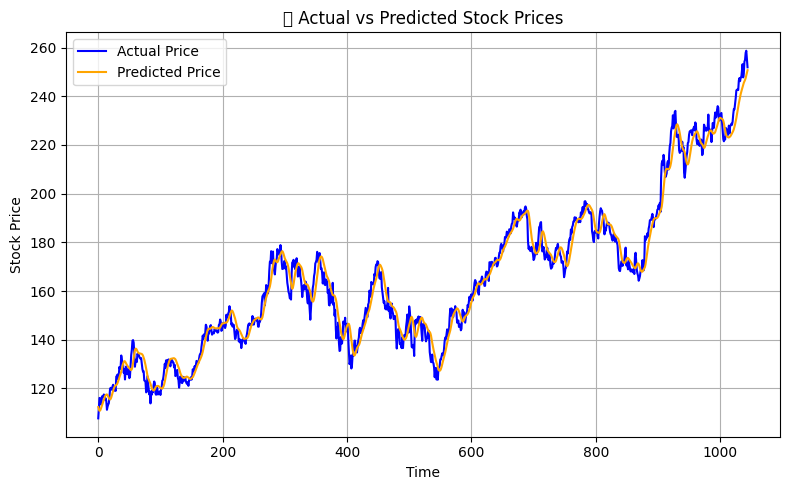

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# TSLA

In [105]:
path = r'C:\Complete Project\Stock-Price-Prediction-using-LSTM\historical_data\TSLA.csv'

In [106]:
data = pd.read_csv(path)

In [107]:
data = preprocess_data(data)

In [108]:
# Extract closing price for simplicity
data = data[['Close']]

# Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [109]:
# Create sequences of data
X, y = create_sequences(scaled_data)

# Reshape X to be 3D (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [110]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

In [111]:
# Build the model
model = build_model(X_train.shape[1:])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,  # Number of epochs to train
                    batch_size=32,  # Batch size
                    callbacks=[early_stopping],  # Early stopping callback
                    verbose=1)


Epoch 1/50


C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - loss: 0.0011 - val_loss: 0.0038
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 2.7685e-04 - val_loss: 0.0012
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 1.4360e-04 - val_loss: 0.0036
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 1.6539e-04 - val_loss: 0.0014
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 1.1995e-04 - val_loss: 0.0025
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 1.7486e-04 - val_loss: 0.0023
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 1.3029e-04 - val_loss: 0.0013
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - loss: 1.1027e-04 - val_loss: 0.0022
Epoch 9/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - loss: 1.2255e-04 - val_loss: 0.0045
Epoch 10/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 1.1110e-04 - val_loss: 4.7037e-04
Epoch 11/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 133ms/step - loss: 1.0532e-04 - val_loss: 0.00

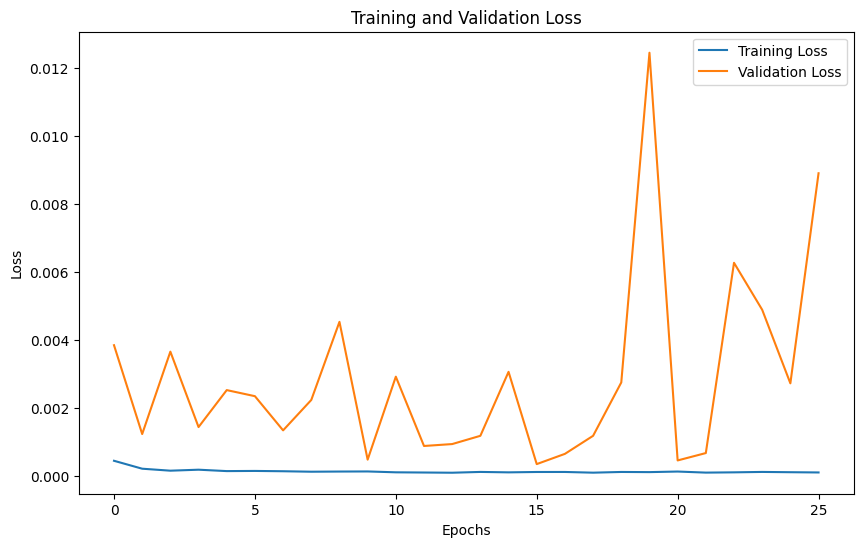

In [112]:
# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [113]:
# Save the trained model
model.save(f'model/TSLA_model.h5')
print("Model saved successfully.")


Model saved successfully.


In [114]:
# Evaluate the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 2.9260e-04
Validation Loss: 0.0003393766819499433


In [115]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model(f'model/AAPL_model.h5')

# Make predictions with the loaded model
loaded_model_predictions = loaded_model.predict(X_val)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Inverse transform the predictions and actual values back to original scale
y_pred = scaler.inverse_transform(loaded_model_predictions)
y_true = scaler.inverse_transform(y_val.reshape(-1, 1))

# Compute evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Display results
print(f"📉 Mean Squared Error (MSE): {mse:.4f}")
print(f"📉 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"📉 Mean Absolute Error (MAE): {mae:.4f}")
print(f"📈 R² Score: {r2:.4f}")


📉 Mean Squared Error (MSE): 25.2688
📉 Root Mean Squared Error (RMSE): 5.0268
📉 Mean Absolute Error (MAE): 3.9884
📈 R² Score: 0.9755


C:\Users\POOJA\AppData\Local\Temp\ipykernel_3604\968185722.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\POOJA\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


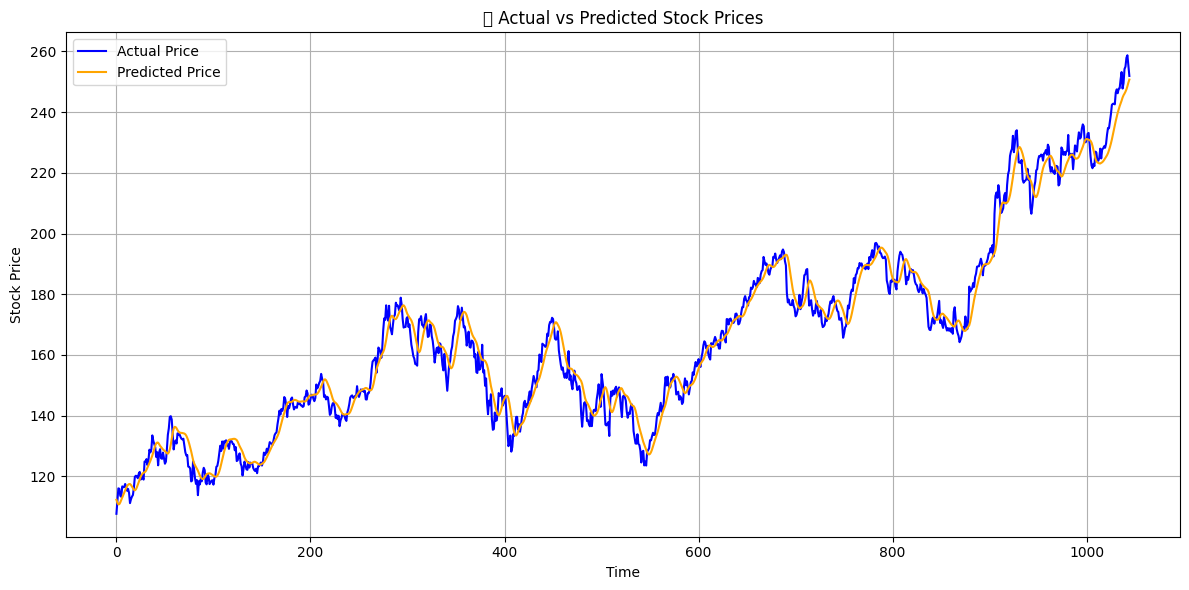

In [117]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual Price', color='blue')
plt.plot(y_pred, label='Predicted Price', color='orange')
plt.title('📈 Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
